In [1]:
import torch
from torch.distributions import constraints
from collections import defaultdict


import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.optim import Adam
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO

from matplotlib import pyplot
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import matplotlib.pylab as plt

In [4]:
torch.set_default_tensor_type(torch.FloatTensor)

In [5]:
pyro.enable_validation(True)

From https://pyro.ai/examples/intro_part_i.html

Primitive stochastic functions, or distributions, are an important class of stochastic functions for which we can explicitly compute the probability of the outputs given the inputs. 

All probabilistic programs are built up by composing primitive stochastic functions and deterministic computation.

In [6]:
def independentGaussian(data):
    obs_dim, data_dim = data.shape
    with pyro.plate('features', data_dim):
        locs = pyro.sample('locs', pyro.distributions.Normal(0.,10.**2))
        scales = pyro.sample('scales', pyro.distributions.LogNormal(0.,10.))
        with pyro.plate('data', obs_dim):
            data = pyro.sample('obs', pyro.distributions.Normal(locs,scales), obs=data)
    return data

In [7]:
N, D = 1000, 10
some_data_locs = np.random.randn(D)*10
some_data_scales = np.sqrt((np.random.randn(D)*10)**2)
data = np.random.randn(N,D)*some_data_scales + some_data_locs
data = np.float32(data) # float64 creates mismatch with torch's defaults
data = torch.tensor(data)

In [8]:
independentGaussian(data)

tensor([[ -9.4192, -21.7814,   1.9400,  ...,  14.3590,  -0.2999, -36.8426],
        [ -1.3494, -24.5160,   5.5487,  ...,  11.4245,   6.8048, -12.0337],
        [ -4.3939, -15.9858,   0.9683,  ..., -15.1651,   6.8780,  -4.3801],
        ...,
        [ -5.1576,  -1.7955,   8.0792,  ...,  -1.5464,   7.7288, -30.2889],
        [ -1.9783,   4.2474,  -0.3537,  ...,  -3.8835,   7.0837, -28.4011],
        [ -1.9254, -14.5641,   4.9246,  ...,  -3.9226,   7.2972,  19.2853]])

In [9]:
# automatically generated variational model consisting of delta distributions, ie MAP
global_guide = AutoDelta(poutine.block(independentGaussian, expose=['locs', 'scales']))

In [10]:
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
elbo = Trace_ELBO()
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

In [11]:
def initialize(seed):
    # evaluate loss on a randomly initialized parameter-set 
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
    # Initialize means to a single sample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), 1)]);
    pyro.param('auto_scales', (data.var(0) / 2).sqrt(), constraint=constraints.positive)
    loss = svi.loss(independentGaussian, global_guide, data)
    return loss

In [12]:
# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 93, initial_loss = 35073.05859375


In [13]:
pyro.get_param_store().named_parameters()

dict_items([('auto_locs', tensor([[ -5.9583, -14.9625,   3.9615,   1.9110, -10.9261,   0.8164,  19.2716,
           0.4150,   4.6992, -34.2749]], requires_grad=True)), ('auto_scales', tensor([ 0.9222,  2.1561,  0.7848,  2.0748,  2.1600, -0.9847,  1.2990,  1.8596,
         1.1610,  2.6596], requires_grad=True))])

In [14]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [15]:
def rel_err(true_parameter,estimated_parameter):
    if type(true_parameter) != torch.Tensor:
        true_parameter = torch.Tensor(true_parameter)
    norm = torch.norm
    return norm(true_parameter-estimated_parameter)/norm(true_parameter)

In [16]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

tensor(0.0702, grad_fn=<DivBackward0>)
tensor(0.0205, grad_fn=<DivBackward0>)


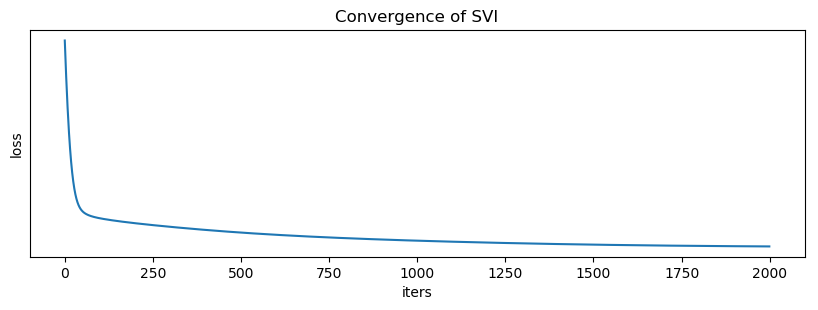

In [17]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

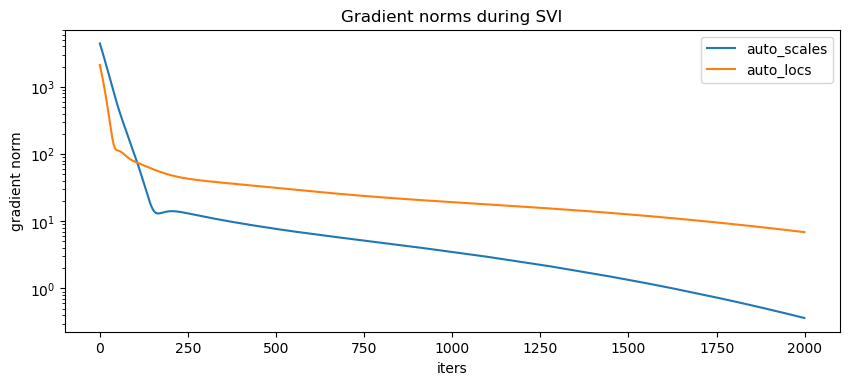

In [18]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [19]:
optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

In [20]:
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

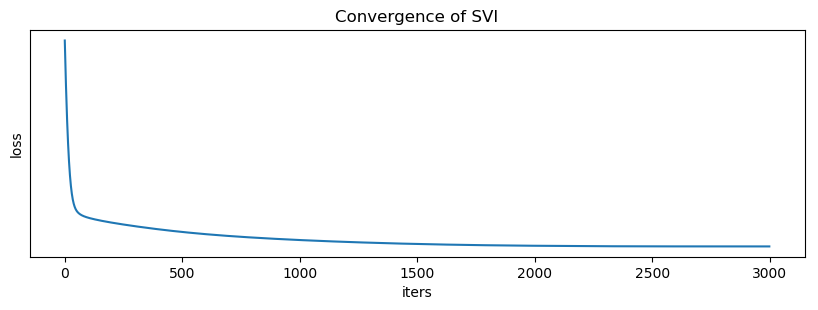

In [21]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

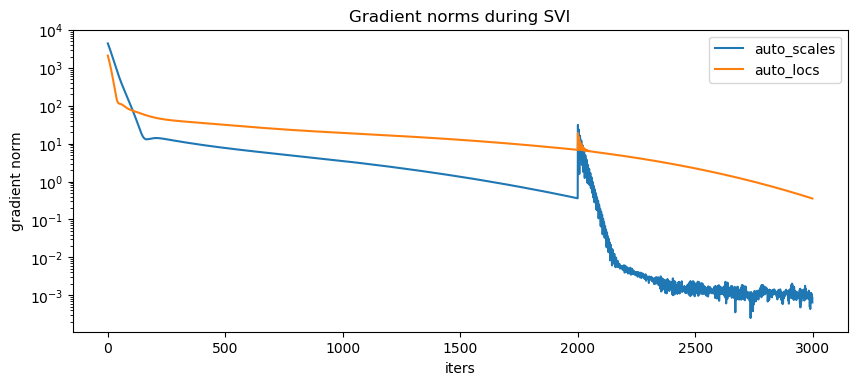

In [22]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [23]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

tensor(0.0266, grad_fn=<DivBackward0>)
tensor(0.0175, grad_fn=<DivBackward0>)


In [ ]:
print(rel_err(some_data_locs,data.mean(0)))
print(rel_err(some_data_scales,pyro.param('auto_scales')))